# Volatility Analysis and Forecasting

This notebook walks through the process of analyzing and forecasting financial volatility. We will cover:
1. Data loading and preprocessing.
2. Calculation of simple and logarithmic returns.
3. Definition and calculation of a proxy for realized volatility (absolute log returns).
4. Stationarity testing using the Augmented Dickey-Fuller (ADF) test.
5. Splitting data into training, validation, and test sets.
6. Visualizing data splits and analyzing autocorrelation (ACF/PACF) of squared returns to identify ARCH/GARCH effects.
7. Establishing baseline forecasting models (mean prediction and random walk).
8. Fitting and evaluating various GARCH-family models (GARCH, GJR-GARCH, EGARCH) using rolling forecasts.
9. Implementing and evaluating an LSTM (Long Short-Term Memory) neural network for volatility forecasting.
10. Using RMSE (Root Mean Squared Error) and RMSPE (Root Mean Squared Percentage Error) for model evaluation.

## 1. Setup and Library Imports

First, we install the `arch` library (if not already installed) which is essential for GARCH modeling. We then import all necessary Python libraries for data manipulation, numerical operations, plotting, date/time handling, statistical analysis, and machine learning.

In [1]:
# Install the arch library for GARCH models (run once)
%pip install arch

# Magic command to display plots inline in Jupyter Notebook
%matplotlib inline

# Standard library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, datetime, timedelta
from scipy import stats

# Scikit-learn for metrics
# r2_score is imported but not used in the provided sequence
from sklearn.metrics import mean_squared_error as mse, r2_score 
# Statsmodels for ADF test and ACF/PACF plots
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ARCH library for GARCH models
from arch import arch_model

# TensorFlow for LSTM model
import tensorflow as tf

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


/Users/daine/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## 2. Data Loading and Initial Visualization

We define a start and end date for our analysis (though these are not directly used for filtering the loaded CSV in this version). We specify a ticker symbol (e.g., 'BTC-USD') and load historical financial data from a CSV file. 

**Note:** The code assumes a CSV file named `abc.csv` is located in a `datasets/` subdirectory. If this file is not found, a dummy dataset is created to allow the notebook to run, but the analysis will not be meaningful.

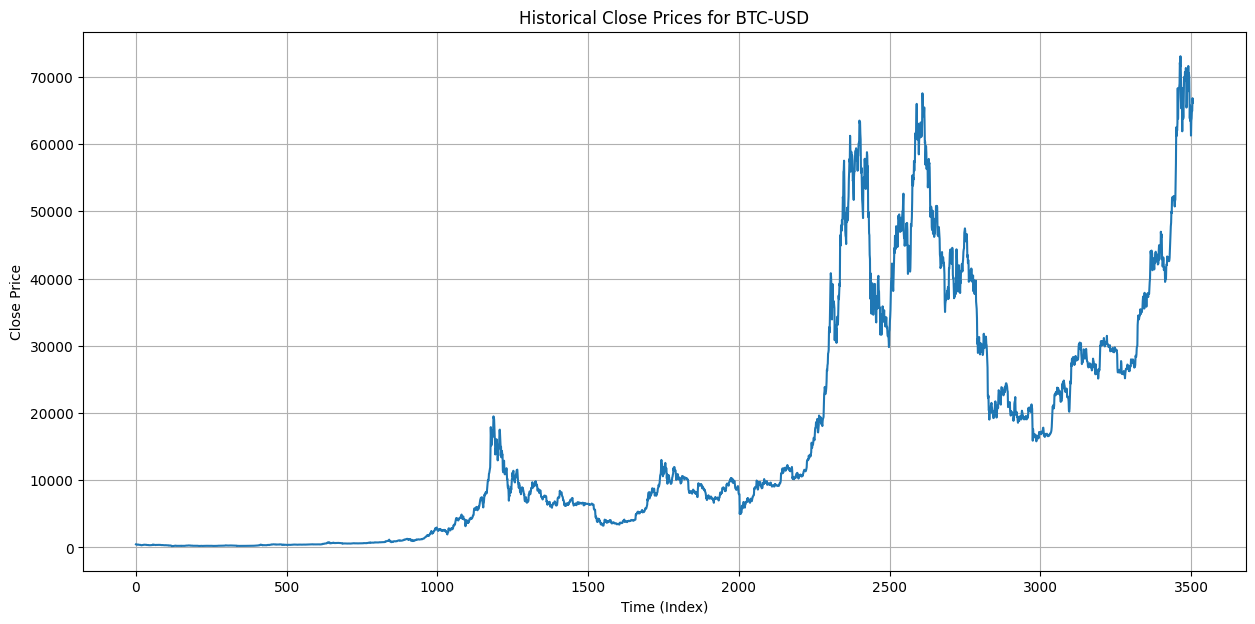

In [2]:
# Define analysis period (not strictly used for filtering CSV in this version)
start_date_param = datetime(2019, 1, 1)
end_date_param = datetime.today()

tckr = 'BTC-USD' # Ticker symbol for labeling

# Load historical data from CSV
# IMPORTANT: Ensure 'datasets/abc.csv' exists or modify the path.
# The CSV should ideally have at least a 'Close' column. A 'Date' column is also common.
try:
    ticker_historical = pd.read_csv('datasets/abc.csv')
    # If your CSV has a 'Date' column that needs parsing and to be set as index:
    # if 'Date' in ticker_historical.columns:
    #     ticker_historical['Date'] = pd.to_datetime(ticker_historical['Date'])
    #     ticker_historical.set_index('Date', inplace=True)
except FileNotFoundError:
    print("Error: 'datasets/abc.csv' not found. A dummy dataset will be used.")
    # Create a dummy DataFrame if the file is not found
    num_dummy_points = 3000 # Ensure enough points for splits
    dummy_dates = pd.to_datetime([datetime(2020,1,1) + timedelta(days=x) for x in range(num_dummy_points)])
    ticker_historical = pd.DataFrame({
        'Date': dummy_dates, # Optional: can be used as index
        'Open': np.random.rand(num_dummy_points) * 10000 + 20000,
        'High': np.random.rand(num_dummy_points) * 10000 + 21000,
        'Low': np.random.rand(num_dummy_points) * 10000 + 19000,
        'Close': np.random.rand(num_dummy_points) * 10000 + 20000, # Essential column
        'Volume': np.random.rand(num_dummy_points) * 100
    })
    # ticker_historical.set_index('Date', inplace=True) # If using Date as index

# Plot historical closing prices
plt.figure(figsize=(15,7))
plt.plot(ticker_historical['Close'])
plt.title(f'Historical Close Prices for {tckr}')
plt.xlabel('Time (Index)') # Change to 'Date' if Date index is used
plt.ylabel('Close Price')
plt.grid(True)
plt.show()

## 3. Calculating Returns

Financial time series analysis often works with returns rather than raw prices, as returns tend to have better statistical properties (e.g., stationarity).

- **Simple Returns**: \( R_t = (P_t - P_{t-1}) / P_{t-1} \)
- **Logarithmic Returns (Log Returns)**: \( r_t = \ln(P_t / P_{t-1}) = \ln(P_t) - \ln(P_{t-1}) \)

Log returns are often preferred for their additive property over time and because they are more likely to be normally distributed.

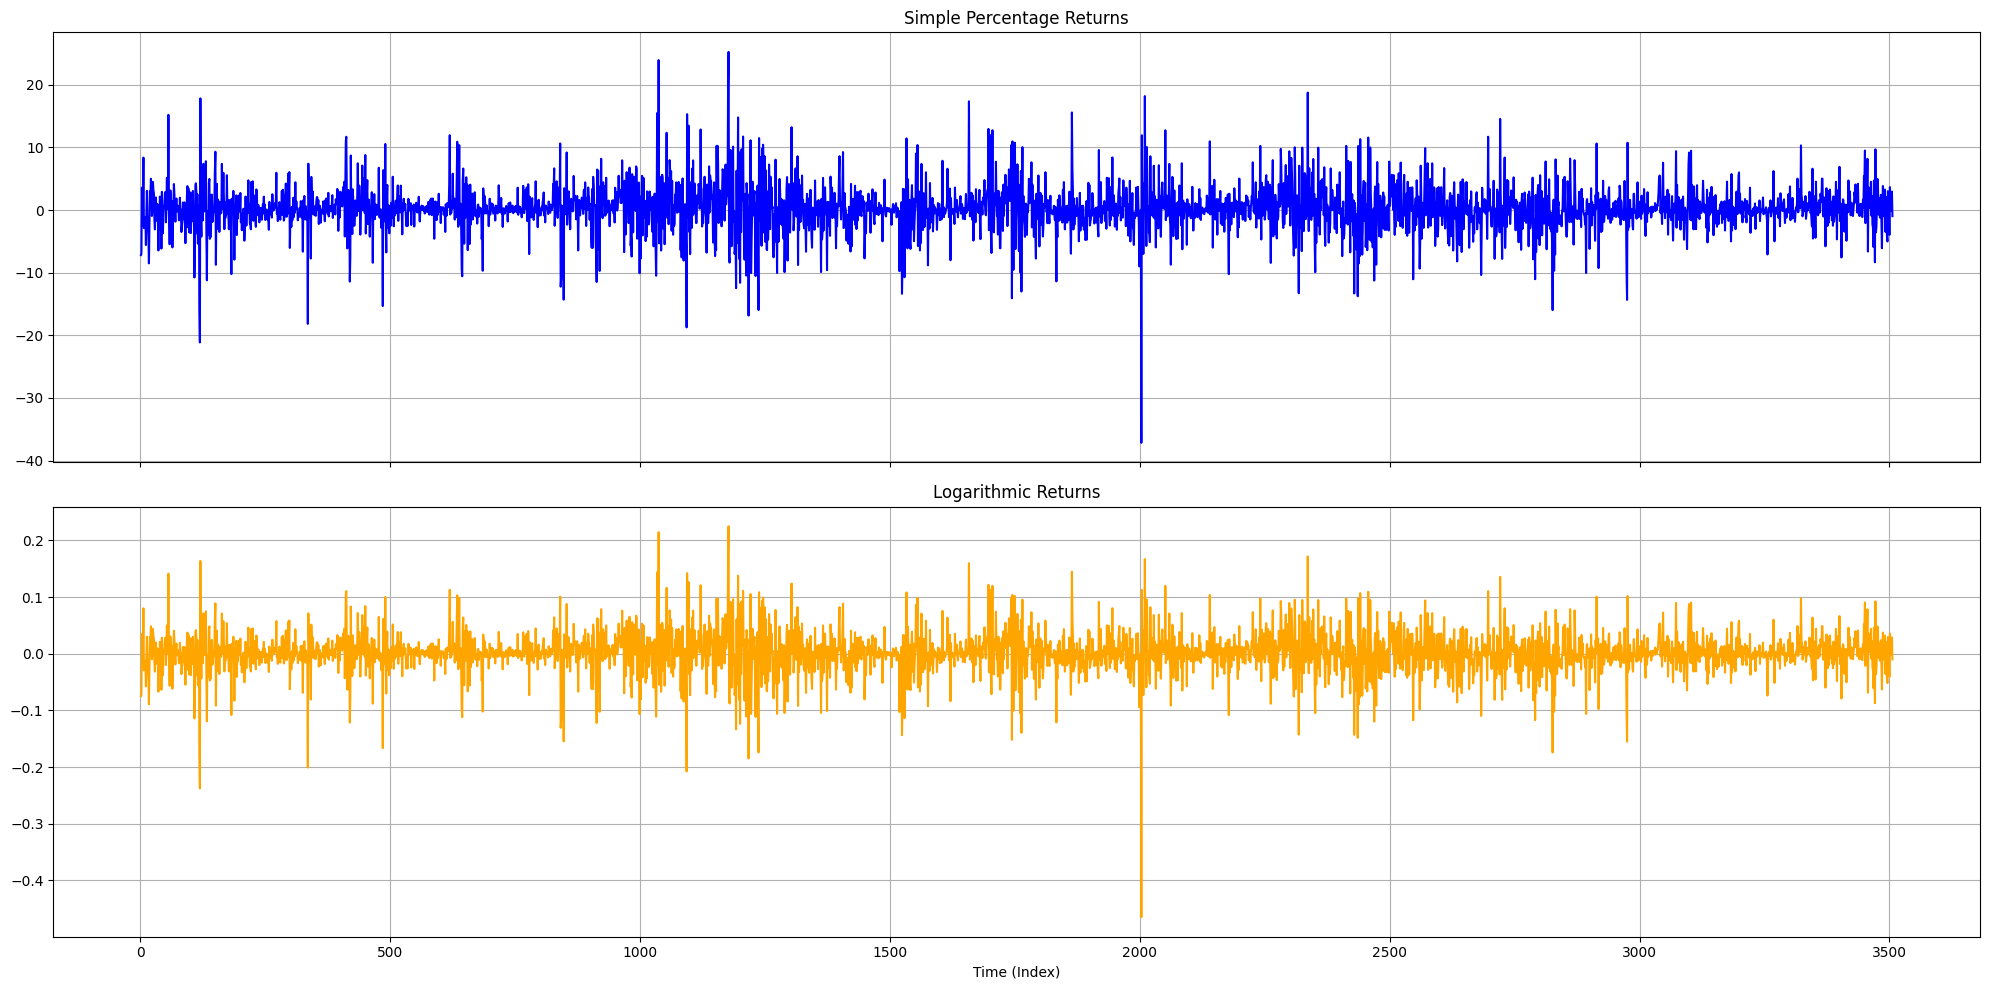

Descriptive statistics for simple returns:
count    3506.000000
mean        0.210328
std         3.681248
min       -37.169539
25%        -1.241155
50%         0.142533
75%         1.728504
max        25.247169
Name: Close, dtype: float64

Descriptive statistics for log returns:
count    3506.000000
mean        0.001419
std         0.037092
min        -0.464730
25%        -0.012489
50%         0.001424
75%         0.017137
max         0.225119
Name: Close, dtype: float64


In [3]:
# Calculate simple percentage returns
returns = 100 * ticker_historical.Close.pct_change().dropna()

# Calculate logarithmic returns
log_returns = np.log(ticker_historical.Close/ticker_historical.Close.shift(1)).dropna()

# Visualize simple returns vs. log returns
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20,10), sharex=True)

ax1.plot(returns.index, returns, color='blue')
ax1.set_title('Simple Percentage Returns')
ax1.grid(True)

ax2.plot(log_returns.index, log_returns, color='orange')
ax2.set_title('Logarithmic Returns')
ax2.grid(True)
ax2.set_xlabel('Time (Index)')

plt.tight_layout()
plt.show();

# Display descriptive statistics for both types of returns
print("Descriptive statistics for simple returns:")
print(returns.describe())
print("\nDescriptive statistics for log returns:")
print(log_returns.describe())

#### Distribution of Returns
We plot histograms of the simple and log returns and overlay a fitted normal distribution to visually assess their distributional properties, particularly looking for characteristics like 'fat tails' (leptokurtosis) common in financial returns.

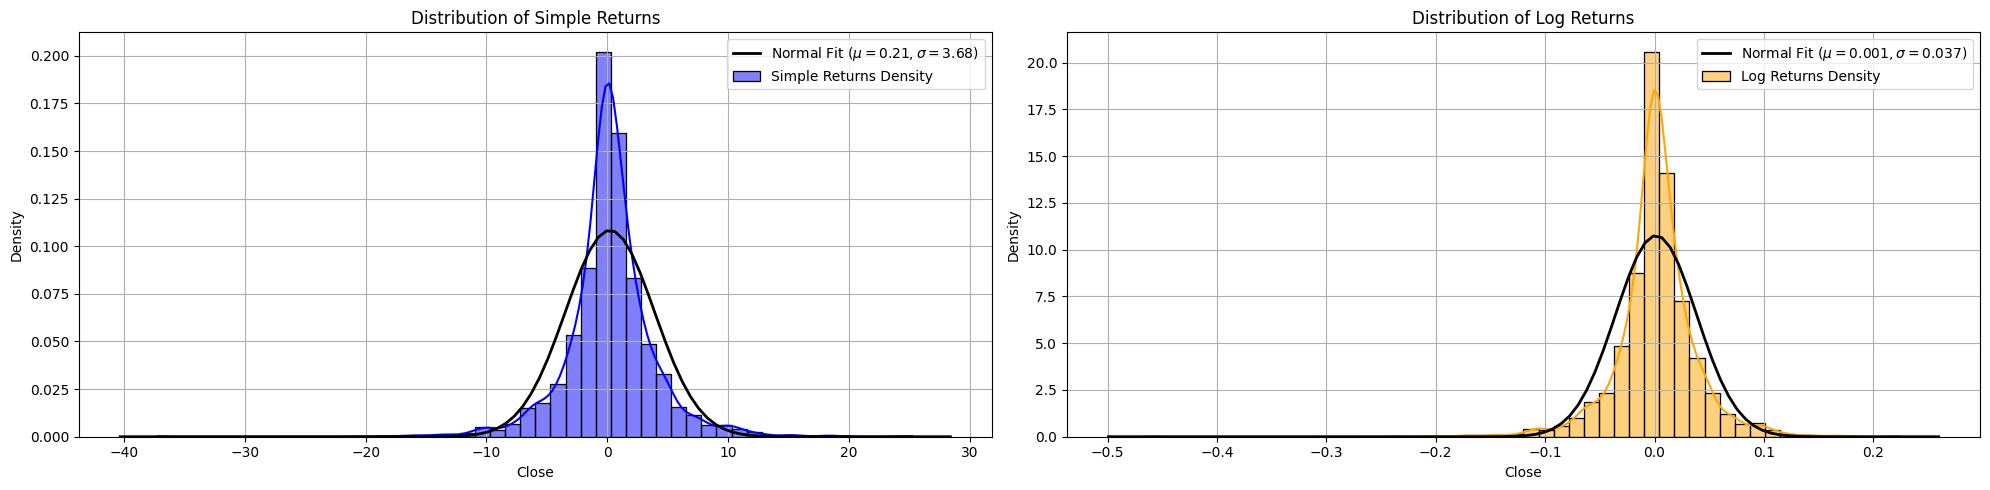

In [4]:
# PLOT DISTRIBUTION PLOTS OF RETURNS & LOG RETURNS
# AND VISUALLY COMPARE THEM WITH THE STANDARD NORMAL DISTRIBUTION
if not returns.empty and not log_returns.empty:
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
    
    # Distribution of Simple Returns
    sns.histplot(returns, stat='density', kde=True, color='blue', bins=50, ax=ax1, label='Simple Returns Density')
    # Fit a normal distribution to the data
    mu_simple, std_simple = stats.norm.fit(returns)
    xmin_simple, xmax_simple = ax1.get_xlim()
    x_simple = np.linspace(xmin_simple, xmax_simple, 100)
    p_simple = stats.norm.pdf(x_simple, mu_simple, std_simple)
    ax1.plot(x_simple, p_simple, 'k', linewidth=2, label=f'Normal Fit ($\mu={mu_simple:.2f}, \sigma={std_simple:.2f}$)')
    ax1.set_title('Distribution of Simple Returns')
    ax1.legend()
    ax1.grid(True)

    # Distribution of Log Returns
    sns.histplot(log_returns, stat='density', kde=True, color='orange', bins=50, ax=ax2, label='Log Returns Density')
    # Fit a normal distribution to the data
    mu_log, std_log = stats.norm.fit(log_returns)
    xmin_log, xmax_log = ax2.get_xlim()
    x_log = np.linspace(xmin_log, xmax_log, 100)
    p_log = stats.norm.pdf(x_log, mu_log, std_log)
    ax2.plot(x_log, p_log, 'k', linewidth=2, label=f'Normal Fit ($\mu={mu_log:.3f}, \sigma={std_log:.3f}$)')
    ax2.set_title('Distribution of Log Returns')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show();
else:
    print("Returns or log_returns series is empty. Skipping distribution plots.")

## 4. Realized Volatility Proxy

We define a function to calculate 'realized volatility'. In the context of applying it to individual log returns (as done with `.apply()`), this function effectively calculates the absolute value of each log return: \( |r_t| \). This serves as a simple daily proxy for volatility – the magnitude of price changes.

If the function were applied to a *series* of log returns (e.g., all returns in a month), it would calculate the standard definition of realized volatility for that period: \( \sqrt{\sum r_t^2} \).

In [5]:
# Function to calculate realized volatility (or absolute value for single returns)
def realized_volatility(series_log_return):
    """
    Calculates the square root of the sum of squares of log returns.
    If applied to a single scalar (e.g., via pandas .apply()), 
    it returns the absolute value of that scalar.
    """
    if np.isscalar(series_log_return):
        return np.sqrt(series_log_return**2) # This is equivalent to abs(series_log_return)
    return np.sqrt(np.sum(series_log_return**2))

# Apply the function to get a series of daily volatility proxies (absolute log returns)
# This 'vols' series will be our target variable for volatility forecasting.
vols = log_returns.apply(realized_volatility) 

print("First 5 values of our daily volatility proxy (absolute log returns):")
print(vols.head())

First 5 values of our daily volatility proxy (absolute log returns):
1    0.074643
2    0.072402
3    0.035111
4    0.024968
5    0.008317
Name: Close, dtype: float64


## 5. Stationarity Test (Augmented Dickey-Fuller)

Many time series models, including GARCH models (which model volatility of stationary returns), assume that the underlying time series is stationary. A time series is stationary if its statistical properties (mean, variance, autocorrelation) are constant over time.

The Augmented Dickey-Fuller (ADF) test is used to test for a unit root, which indicates non-stationarity.
- **Null Hypothesis (H0)**: The series has a unit root (it is non-stationary).
- **Alternative Hypothesis (H1)**: The series does not have a unit root (it is stationary).

We look at the p-value: 
- If p-value ≤ 0.05 (or other chosen significance level), we reject H0 and conclude the series is likely stationary.
- If p-value > 0.05, we fail to reject H0 and conclude the series is likely non-stationary.

Log returns are often stationary, while price series are typically non-stationary.

In [6]:
# Perform ADF test on log returns
if not log_returns.empty:
    adfuller_results = adfuller(log_returns)
    print(f'ADF Test Results for Log Returns ({tckr}):')
    print(f'  ADF Statistic: {adfuller_results[0]}')
    print(f'  p-value: {adfuller_results[1]}')
    print('  Critical Values:')
    for key, value in adfuller_results[4].items():
        print(f'    {key}: {value:.4f}')
    if adfuller_results[1] <= 0.05:
        print("  Conclusion: Reject H0. The log return series is likely stationary.")
    else:
        print("  Conclusion: Fail to reject H0. The log return series is likely non-stationary.")
else:
    print("Log returns series is empty, skipping ADF test.")
    
print("\nSummary information for the original ticker_historical DataFrame:")
ticker_historical.info()

ADF Test Results for Log Returns (BTC-USD):
  ADF Statistic: -17.990347259957403
  p-value: 2.7556960442438313e-30
  Critical Values:
    1%: -3.4322
    5%: -2.8624
    10%: -2.5672
  Conclusion: Reject H0. The log return series is likely stationary.

Summary information for the original ticker_historical DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3507 entries, 0 to 3506
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          3507 non-null   object 
 1   Open          3507 non-null   float64
 2   High          3507 non-null   float64
 3   Low           3507 non-null   float64
 4   Close         3507 non-null   float64
 5   Volume        3507 non-null   int64  
 6   Dividends     3507 non-null   float64
 7   Stock Splits  3507 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 219.3+ KB


## 6. Data Splitting

To evaluate our forecasting models, we split the data into three sets:
- **Training Set**: Used to train the models.
- **Validation Set**: Used to tune hyperparameters (if applicable) and make intermediate model selections. Forecasts are generated on this set.
- **Test Set**: Used for a final, unbiased evaluation of the chosen model on unseen data (not explicitly used for forecasting in this notebook sequence, but the split is made).

We split both the `log_returns` series (for GARCH model input) and the `vols` series (our target variable, the absolute log returns).

In [7]:
# Define split points (as integer positions)
split_time_1 = 2000
split_time_2 = 2500

# Ensure log_returns has enough data for the defined splits
if len(log_returns) > split_time_2:
    # Get index labels for each split
    train_idx = log_returns.index[:split_time_1]
    val_idx = log_returns.index[split_time_1:split_time_2]
    test_idx = log_returns.index[split_time_2:]

    # Split log_returns
    ts_train = log_returns[train_idx]
    ts_val = log_returns[val_idx]
    ts_test = log_returns[test_idx]

    # Split 'vols' (our volatility proxy - absolute log returns)
    vol_train = vols[train_idx]
    vol_val = vols[val_idx]
    vol_test = vols[test_idx]
    
    print(f"Total log returns data points: {len(log_returns)}")
    print(f"Training set size (ts_train, vol_train): {len(ts_train)}")
    print(f"Validation set size (ts_val, vol_val): {len(ts_val)}")
    print(f"Test set size (ts_test, vol_test): {len(ts_test)}")
else:
    print(f"Log returns series is too short (length {len(log_returns)}) for the defined splits ({split_time_1}, {split_time_2}).")
    print("Please use a larger dataset or adjust split points.")
    # Create empty series to prevent errors in subsequent cells, though analysis will be compromised
    ts_train, ts_val, ts_test = pd.Series(dtype=float), pd.Series(dtype=float), pd.Series(dtype=float)
    vol_train, vol_val, vol_test = pd.Series(dtype=float), pd.Series(dtype=float), pd.Series(dtype=float)
    # vols might not have been defined if log_returns was empty earlier
    if 'vols' not in locals(): vols = pd.Series(dtype=float) 
    train_idx, val_idx, test_idx = pd.Index([]), pd.Index([]), pd.Index([])

Total log returns data points: 3506
Training set size (ts_train, vol_train): 2000
Validation set size (ts_val, vol_val): 500
Test set size (ts_test, vol_test): 1006


## 7. Visualizing Splits and ACF/PACF of Squared Returns

We visualize how the 'volatility' (absolute log returns) is split across training, validation, and test sets.

Then, we plot the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) of the **squared log returns** from the training set (`ts_train**2`).
- **Why squared returns?** Volatility clustering (ARCH/GARCH effects) manifests as autocorrelation in the squared returns (or squared residuals).
- **PACF of squared returns**: Helps identify the order 'p' of the ARCH component in a GARCH(p,q) model. Significant spikes cutting off after lag 'p' suggest an ARCH(p) process.
- **ACF of squared returns**: Helps identify the order 'q' of the GARCH component. Significant spikes suggest GARCH effects; a slow decay might indicate a GARCH(q) process.

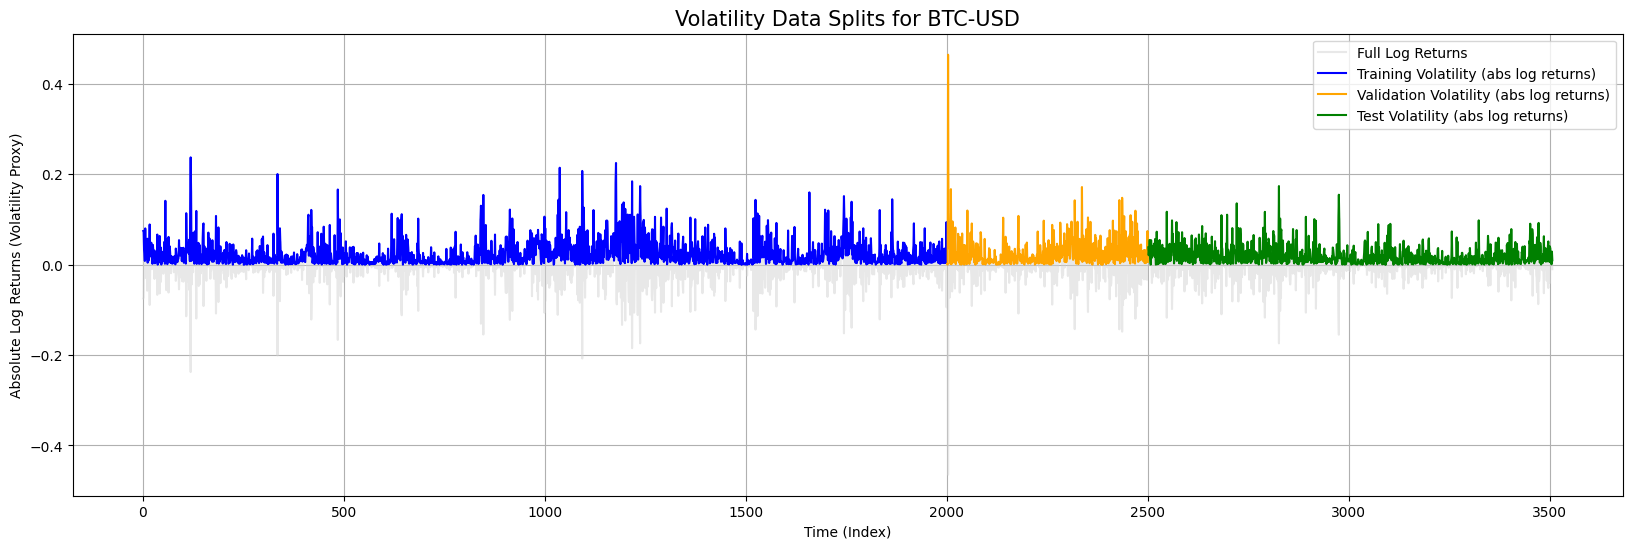

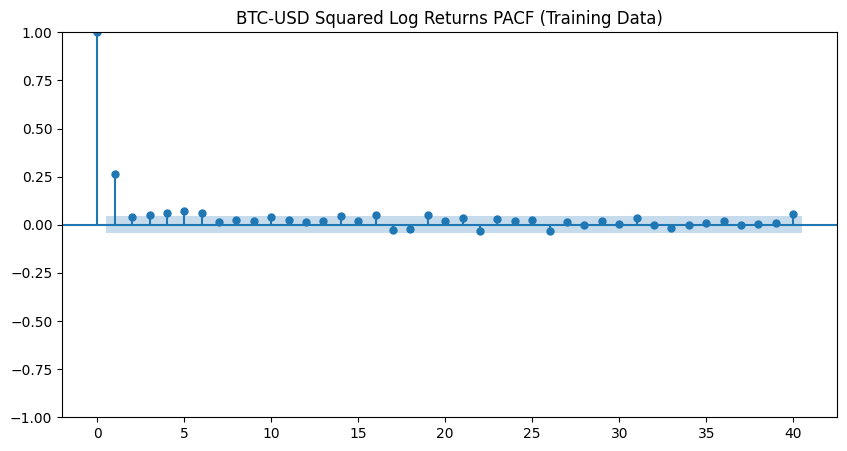

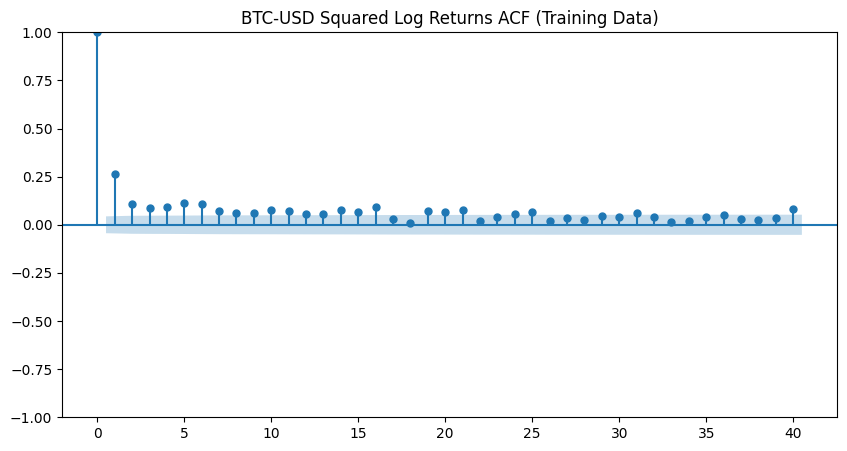

In [8]:
if not vol_train.empty and not vol_val.empty and not vol_test.empty:
    plt.figure(figsize=(20,6))
    # Plot entire log returns series lightly in the background for context
    plt.plot(log_returns.index, log_returns, color='lightgray', label='Full Log Returns', alpha=0.5)
    
    # Plot the 'volatility' (absolute log returns) for each split
    plt.plot(vol_train.index, vol_train, color='blue', label='Training Volatility (abs log returns)')
    plt.plot(vol_val.index, vol_val, color='orange', label='Validation Volatility (abs log returns)')
    plt.plot(vol_test.index, vol_test, color='green', label='Test Volatility (abs log returns)')
    
    plt.title(f'Volatility Data Splits for {tckr}', fontsize=15)
    plt.xlabel('Time (Index)')
    plt.ylabel('Absolute Log Returns (Volatility Proxy)')
    plt.legend()
    plt.grid(True)
    plt.show();

    # Plot PACF of squared training log returns
    fig, ax = plt.subplots(figsize=(10,5))
    plot_pacf(ts_train**2, ax=ax, title=f'{tckr.upper()} Squared Log Returns PACF (Training Data)', lags=40);
    plt.show();

    # Plot ACF of squared training log returns
    fig, ax = plt.subplots(figsize=(10,5))
    plot_acf(ts_train**2, ax=ax, title=f'{tckr.upper()} Squared Log Returns ACF (Training Data)', lags=40);
    plt.show();
else:
    print("Data splits are empty. Skipping split visualization and ACF/PACF plots.")

## 8. Baseline Models for Volatility Forecasting

Before building complex models, we establish simple baselines to compare against.

### Baseline 1: Mean Prediction
The prediction for every day in the validation set is simply the average 'volatility' (absolute log returns) observed in the training set.

Mean of training volatility (abs log returns): 0.025001


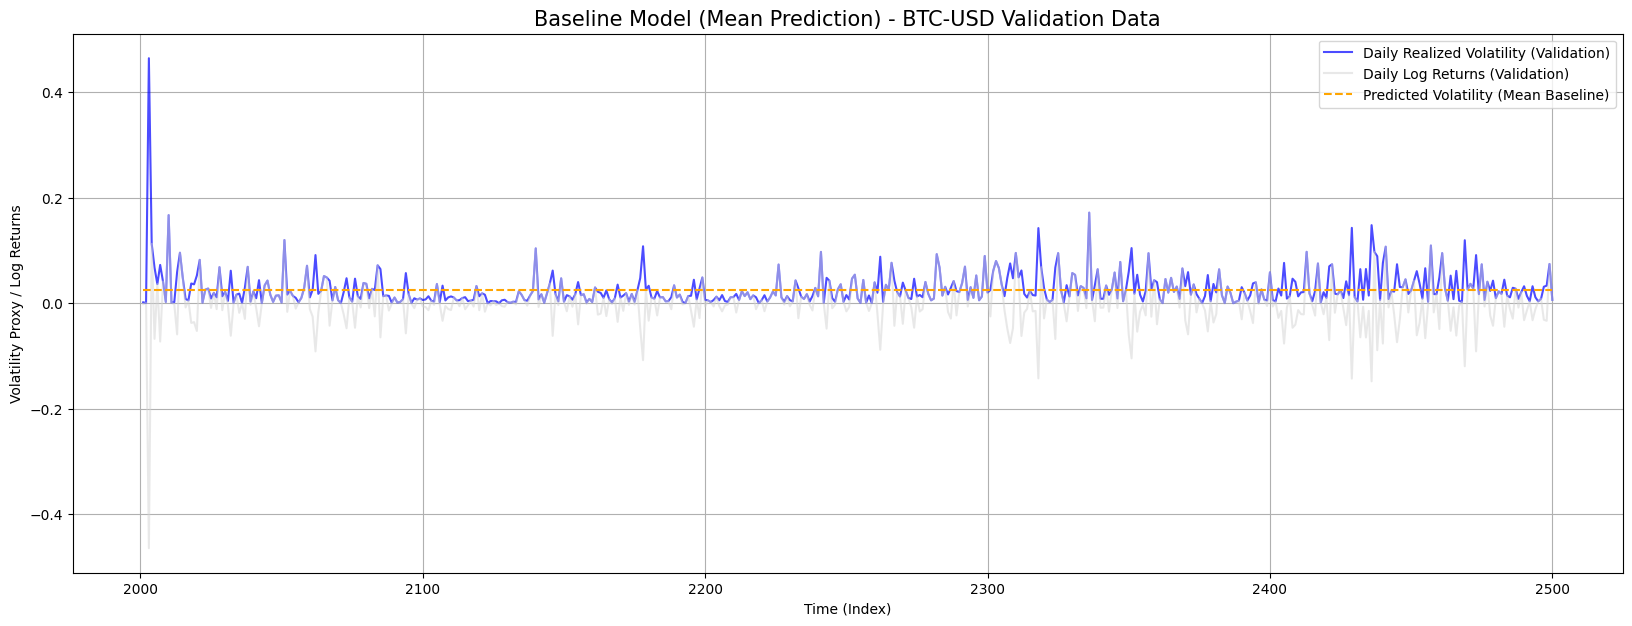

In [9]:
if not vol_train.empty and not vol_val.empty:
    # Calculate the mean of 'volatility' in the training data
    mean_train_vol = vol_train.mean()
    print(f"Mean of training volatility (abs log returns): {mean_train_vol:.6f}")

    # Create baseline predictions: a constant series of the mean training volatility
    baseline_preds_mean = np.ones(len(vol_val)) * mean_train_vol
    baseline_preds_mean = pd.Series(baseline_preds_mean, index=vol_val.index)

    # Visualize baseline predictions against actual validation volatility
    plt.figure(figsize=(20,7))
    plt.plot(vol_val.index, vol_val, color='blue', label='Daily Realized Volatility (Validation)', alpha=0.7)
    plt.plot(ts_val.index, ts_val, color='lightgray', alpha=0.5, label='Daily Log Returns (Validation)') # Context
    plt.plot(baseline_preds_mean.index, baseline_preds_mean, color='orange', linestyle='--', label='Predicted Volatility (Mean Baseline)')

    plt.title(f'Baseline Model (Mean Prediction) - {tckr} Validation Data', fontsize=15)
    plt.xlabel('Time (Index)')
    plt.ylabel('Volatility Proxy / Log Returns')
    plt.legend()
    plt.grid(True)
    plt.show();
else:
    print("Training or validation volatility data is empty, skipping Baseline Model 1 (Mean Prediction).")
    mean_train_vol = np.nan # Define for safety if used later
    baseline_preds_mean = pd.Series(dtype=float) # Define for safety

### Evaluation Metrics: RMSE and RMSPE

We define functions to calculate:
- **RMSE (Root Mean Squared Error)**: \( \sqrt{\frac{1}{n} \sum (y_{true} - y_{pred})^2} \). Penalizes large errors; in the same unit as the target.
- **RMSPE (Root Mean Squared Percentage Error)**: \( \sqrt{\frac{1}{n} \sum (\frac{y_{true} - y_{pred}}{y_{true}})^2} \). Expresses error as a percentage; useful for comparing across scales but sensitive to zero or near-zero true values.

In [10]:
def RMSE(y_true, y_pred):
    """Compute Root Mean Squared Error between 2 arrays, handling NaNs."""
    y_true_arr = np.array(y_true)
    y_pred_arr = np.array(y_pred)
    # Create a mask for valid (non-NaN) pairs
    mask = ~np.isnan(y_true_arr) & ~np.isnan(y_pred_arr)
    if np.sum(mask) == 0: # No valid pairs to compare
        return np.nan
    output = np.sqrt(mse(y_true_arr[mask], y_pred_arr[mask]))
    return output

def RMSPE(y_true, y_pred):
    """Compute Root Mean Squared Percentage Error, handling NaNs and zeros in y_true."""
    y_true_arr = np.array(y_true)
    y_pred_arr = np.array(y_pred)
    # Mask for valid pairs where y_true is also not zero (to avoid division by zero)
    mask = ~np.isnan(y_true_arr) & ~np.isnan(y_pred_arr) & (y_true_arr != 0)
    if np.sum(mask) == 0: # No valid pairs for RMSPE calculation
        return np.nan
    # Calculate percentage error only for valid, non-zero true values
    percentage_errors = (y_true_arr[mask] - y_pred_arr[mask]) / y_true_arr[mask]
    output = np.sqrt(np.mean(np.square(percentage_errors)))
    return output

# Evaluate Baseline Model 1 (Mean Prediction)
if not vol_val.empty and 'baseline_preds_mean' in locals() and not baseline_preds_mean.empty:
    rmse_baseline_mean = RMSE(vol_val, baseline_preds_mean)
    rmspe_baseline_mean = RMSPE(vol_val, baseline_preds_mean)
    print(f"Baseline Model 1 (Mean Prediction) RMSE: {rmse_baseline_mean:.6f}")
    print(f"Baseline Model 1 (Mean Prediction) RMSPE: {rmspe_baseline_mean:.6f}")
else:
    print("Skipping evaluation of Baseline Model 1 due to empty data or undefined predictions.")

Baseline Model 1 (Mean Prediction) RMSE: 0.034473
Baseline Model 1 (Mean Prediction) RMSPE: 65.601969


### Baseline 2: Random Walk (Naive) Forecast
The prediction for tomorrow's 'volatility' is simply today's actual 'volatility'. That is, \( \hat{y}_t = y_{t-1} \).

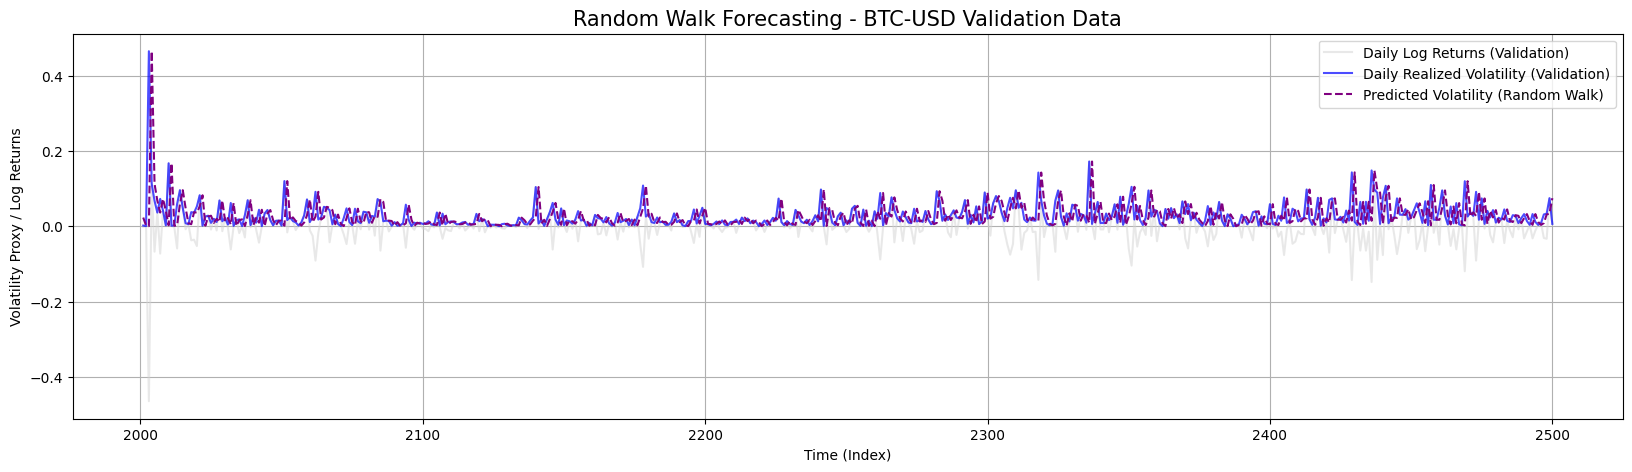

Random Walk Model RMSE: 0.046653
Random Walk Model RMSPE: 48.957284


In [11]:
if not vols.empty and val_idx.is_unique and not val_idx.empty:
    # Create random walk predictions: shift the 'vols' series by 1
    shifted_vols = vols.shift(1).dropna() # y_{t-1}
    
    # Ensure indices for prediction align with available shifted data
    # We can only predict for val_idx if the corresponding y_{t-1} exists in shifted_vols
    valid_val_idx_for_rw = val_idx[val_idx.isin(shifted_vols.index)]
    
    if not valid_val_idx_for_rw.empty:
        random_walk_preds = shifted_vols.loc[valid_val_idx_for_rw]
        
        # Align actual validation data (vol_val and ts_val) with the predictions for fair comparison
        aligned_vol_val_rw = vol_val.loc[valid_val_idx_for_rw]
        aligned_ts_val_rw = ts_val.loc[valid_val_idx_for_rw] # For plotting context

        # Visualize Random Walk predictions
        plt.figure(figsize=(20,5))
        plt.plot(aligned_ts_val_rw.index, aligned_ts_val_rw, color='lightgray', alpha=0.5, label='Daily Log Returns (Validation)')
        plt.plot(aligned_vol_val_rw.index, aligned_vol_val_rw, color='blue', alpha=0.7, label='Daily Realized Volatility (Validation)')
        plt.plot(random_walk_preds.index, random_walk_preds, color='purple', linestyle='--', label='Predicted Volatility (Random Walk)')
        plt.title(f'Random Walk Forecasting - {tckr} Validation Data', fontsize=15)
        plt.xlabel('Time (Index)')
        plt.ylabel('Volatility Proxy / Log Returns')
        plt.legend()
        plt.grid(True)
        plt.show();

        # Evaluate Random Walk Model
        rmse_rw = RMSE(aligned_vol_val_rw, random_walk_preds)
        rmspe_rw = RMSPE(aligned_vol_val_rw, random_walk_preds)
        print(f"Random Walk Model RMSE: {rmse_rw:.6f}")
        print(f"Random Walk Model RMSPE: {rmspe_rw:.6f}")
    else:
        print("Could not create random walk predictions; validation indices not found in shifted data or no overlap.")
        random_walk_preds = pd.Series(dtype=float) # Define for safety
else:
    print("Vols data or validation index is empty/problematic, skipping Random Walk model.")
    random_walk_preds = pd.Series(dtype=float) # Define for safety

## 9. GARCH Models for Volatility Forecasting

GARCH (Generalized Autoregressive Conditional Heteroskedasticity) models are widely used for modeling financial time series volatility. They capture time-varying variance and volatility clustering.

### GARCH(1,1) Model
The GARCH(1,1) model is a common starting point. Its conditional variance \( \sigma_t^2 \) is modeled as:
$$ \sigma_t^2 = \omega + \alpha_1 \epsilon_{t-1}^2 + \beta_1 \sigma_{t-1}^2 $$
where \( \epsilon_{t-1}^2 \) is the squared residual (shock) from the previous period (ARCH term), and \( \sigma_{t-1}^2 \) is the conditional variance from the previous period (GARCH term).

We first fit the model to the training data (`ts_train`) to examine its parameters.

GARCH(1,1) Model Fit Summary (on Training Data):
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                3900.71
Distribution:                  Normal   AIC:                          -7795.42
Method:            Maximum Likelihood   BIC:                          -7778.62
                                        No. Observations:                 2000
Date:                Mon, Feb 02 2026   Df Residuals:                     2000
Time:                        10:16:07   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega    

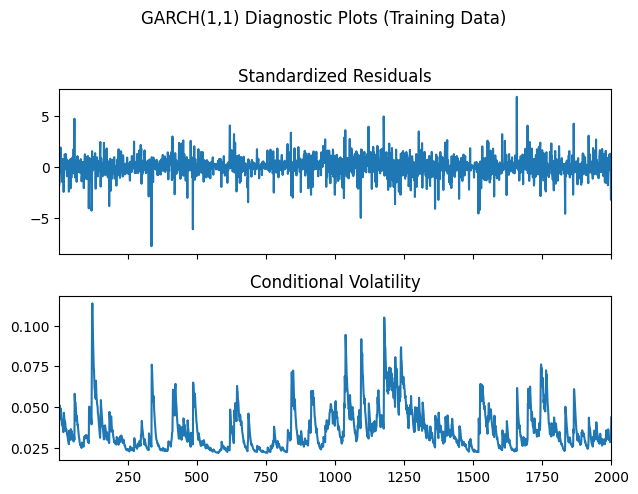

In [12]:
if not ts_train.empty:
    # Define and fit GARCH(1,1) model to the training log returns
    # mean='Zero' assumes log returns have zero mean
    # dist='normal' assumes normally distributed errors
    gm_1_garch11 = arch_model(ts_train, vol='GARCH', p=1, q=1,
                              mean='Zero', dist='normal')
    result_1_garch11 = gm_1_garch11.fit(disp='off', show_warning=False) # disp='off' suppresses optimizer output
    print("GARCH(1,1) Model Fit Summary (on Training Data):")
    print(result_1_garch11.summary())

    # Plot diagnostic plots for the fitted GARCH(1,1) model
    result_1_garch11.plot()
    plt.suptitle("GARCH(1,1) Diagnostic Plots (Training Data)", y=1.02)
    plt.tight_layout()
    plt.show();
else:
    print("Training data (ts_train) is empty, skipping GARCH(1,1) model fitting.")
    result_1_garch11 = None # Define for safety

#### GARCH(1,1) Rolling Forecast
To evaluate out-of-sample performance, we use a rolling (expanding window) forecast. At each step in the validation period:
1. The GARCH(1,1) model is re-trained using all historical data up to that point.
2. A 1-step ahead forecast of volatility (square root of conditional variance) is made.

**Note:** This process can be computationally intensive due to repeated model fitting.

Starting GARCH(1,1) rolling forecast (this may take time)...
  GARCH(1,1) forecast step 1/500 completed.
  GARCH(1,1) forecast step 51/500 completed.
  GARCH(1,1) forecast step 101/500 completed.
  GARCH(1,1) forecast step 151/500 completed.
  GARCH(1,1) forecast step 201/500 completed.
  GARCH(1,1) forecast step 251/500 completed.
  GARCH(1,1) forecast step 301/500 completed.
  GARCH(1,1) forecast step 351/500 completed.
  GARCH(1,1) forecast step 401/500 completed.
  GARCH(1,1) forecast step 451/500 completed.
  GARCH(1,1) forecast step 500/500 completed.


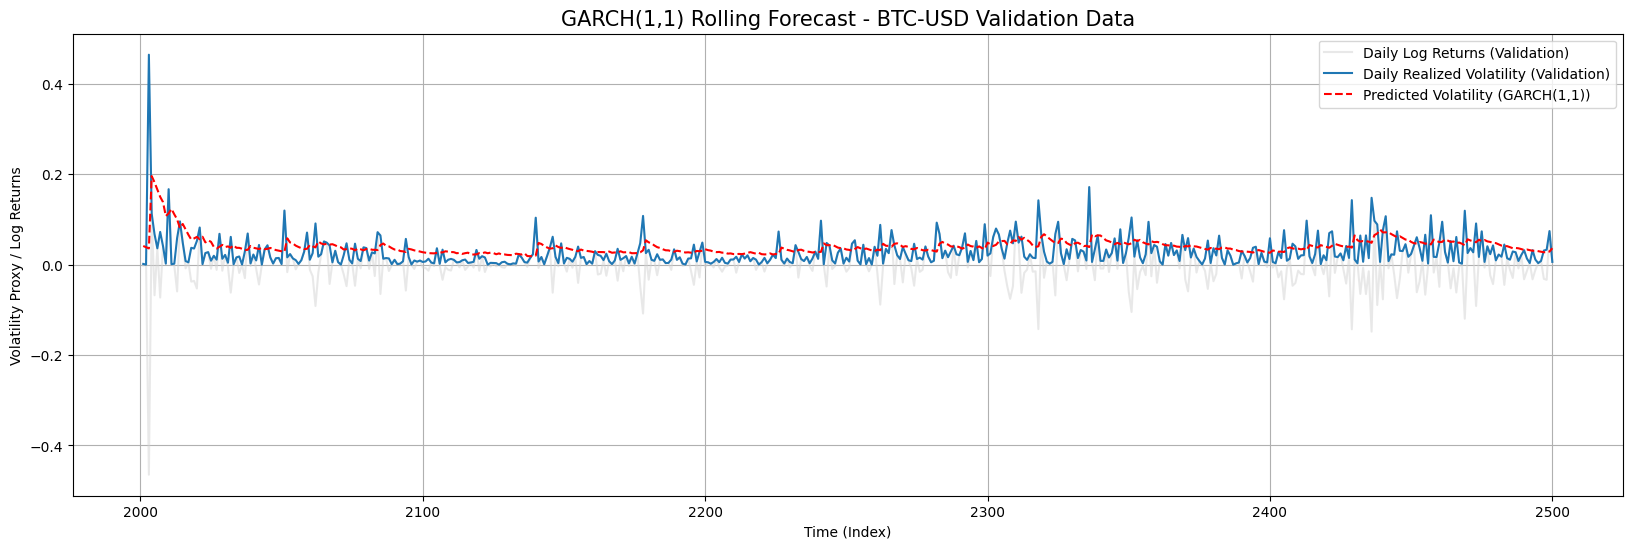

GARCH(1,1) Model Rolling Forecast RMSE: 0.037767
GARCH(1,1) Model Rolling Forecast RMSPE: 84.328945
Finished GARCH(1,1) rolling forecast.


In [13]:
rolling_predictions_garch11 = pd.Series(dtype=float) # Initialize
if not ts_val.empty and not log_returns.empty:
    print("Starting GARCH(1,1) rolling forecast (this may take time)...")
    rolling_forecasts_garch11_list = []

    for i in range(len(ts_val)):
        current_validation_index_label = val_idx[i] 
        # Expanding window: use all data up to (but not including) the current validation point
        # Get the position of the current_validation_index_label in log_returns.index
        loc_current_val_in_log_returns = log_returns.index.get_loc(current_validation_index_label)
        current_training_window = log_returns.iloc[:loc_current_val_in_log_returns] # Slice up to, but not including, current val point
        
        if len(current_training_window) < 20: # Minimum data points to fit a GARCH model
            rolling_forecasts_garch11_list.append(np.nan)
            if i % 50 == 0: print(f"  GARCH(1,1) forecast step {i+1}/{len(ts_val)} (skipped, too few points: {len(current_training_window)})")
            continue
            
        model = arch_model(current_training_window, vol='GARCH', p=1, q=1,
                           mean='Zero', dist='normal')
        try:
            model_fit = model.fit(disp='off', show_warning=False)
            # Forecast 1 step ahead, get variance, then sqrt for volatility
            pred_variance = model_fit.forecast(horizon=1, reindex=False).variance.iloc[-1,0]
            pred_volatility = np.sqrt(pred_variance)
            rolling_forecasts_garch11_list.append(pred_volatility)
        except Exception as e:
            # print(f"Error fitting GARCH(1,1) at validation step {i} for index {current_validation_index_label}: {e}") # For debugging
            rolling_forecasts_garch11_list.append(np.nan) # Append NaN if model fitting fails
        if i % 50 == 0 or i == len(ts_val) -1 : print(f"  GARCH(1,1) forecast step {i+1}/{len(ts_val)} completed.")
            
    rolling_predictions_garch11 = pd.Series(rolling_forecasts_garch11_list, index=ts_val.index)

    # Visualize GARCH(1,1) rolling forecasts
    plt.figure(figsize=(20,6))
    plt.plot(ts_val.index, ts_val, color='lightgray', alpha=0.5, label='Daily Log Returns (Validation)')
    plt.plot(vol_val.index, vol_val, label='Daily Realized Volatility (Validation)')
    plt.plot(rolling_predictions_garch11.index, rolling_predictions_garch11, color='red', linestyle='--', label='Predicted Volatility (GARCH(1,1))')
    plt.title(f'GARCH(1,1) Rolling Forecast - {tckr} Validation Data', fontsize=15)
    plt.xlabel('Time (Index)')
    plt.ylabel('Volatility Proxy / Log Returns')
    plt.legend()
    plt.grid(True)
    plt.show();

    # Evaluate GARCH(1,1) rolling forecasts
    rmse_garch11 = RMSE(vol_val, rolling_predictions_garch11)
    rmspe_garch11 = RMSPE(vol_val, rolling_predictions_garch11)
    print(f"GARCH(1,1) Model Rolling Forecast RMSE: {rmse_garch11:.6f}")
    print(f"GARCH(1,1) Model Rolling Forecast RMSPE: {rmspe_garch11:.6f}")
    print("Finished GARCH(1,1) rolling forecast.")
else:
    print("Validation or log returns data is empty, skipping GARCH(1,1) rolling forecast.")

### GJR-GARCH Model
The GJR-GARCH model (Glosten-Jagannathan-Runkle GARCH) extends GARCH to account for the leverage effect: negative shocks (bad news) tend to increase volatility more than positive shocks (good news) of the same magnitude.
The GJR-GARCH(1,1,1) conditional variance is:
$$ \sigma_t^2 = \omega + \alpha_1 \epsilon_{t-1}^2 + \gamma_1 \epsilon_{t-1}^2 I_{t-1} + \beta_1 \sigma_{t-1}^2 $$
where \( I_{t-1} = 1 \) if \( \epsilon_{t-1} < 0 \) (negative shock) and \( 0 \) otherwise. A positive and significant \( \gamma_1 \) indicates a leverage effect.

We fit it to `ts_train` first.

In [14]:
if not ts_train.empty:
    # Define and fit GJR-GARCH(1,1,1) model (p=1, o=1, q=1)
    # o=1 includes the asymmetric term for leverage effect
    gjr_gm_fit = arch_model(ts_train, p=1, o=1, q=1, mean='Zero', vol='GARCH', dist='normal')
    result_2_gjr = gjr_gm_fit.fit(disp='off', show_warning=False)
    print("GJR-GARCH(1,1,1) Model Fit Summary (on Training Data):")
    print(result_2_gjr.summary())
else:
    print("Training data (ts_train) is empty, skipping GJR-GARCH model fitting.")
    result_2_gjr = None # Define for safety

GJR-GARCH(1,1,1) Model Fit Summary (on Training Data):
                     Zero Mean - GJR-GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:                3889.02
Distribution:                  Normal   AIC:                          -7770.03
Method:            Maximum Likelihood   BIC:                          -7747.63
                                        No. Observations:                 2000
Date:                Mon, Feb 02 2026   Df Residuals:                     2000
Time:                        10:16:16   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------


#### GJR-GARCH Rolling Forecast

Starting GJR-GARCH rolling forecast (this may take time)...
  GJR-GARCH forecast step 1/500 completed.
  GJR-GARCH forecast step 51/500 completed.
  GJR-GARCH forecast step 101/500 completed.
  GJR-GARCH forecast step 151/500 completed.
  GJR-GARCH forecast step 201/500 completed.
  GJR-GARCH forecast step 251/500 completed.
  GJR-GARCH forecast step 301/500 completed.
  GJR-GARCH forecast step 351/500 completed.
  GJR-GARCH forecast step 401/500 completed.
  GJR-GARCH forecast step 451/500 completed.
  GJR-GARCH forecast step 500/500 completed.


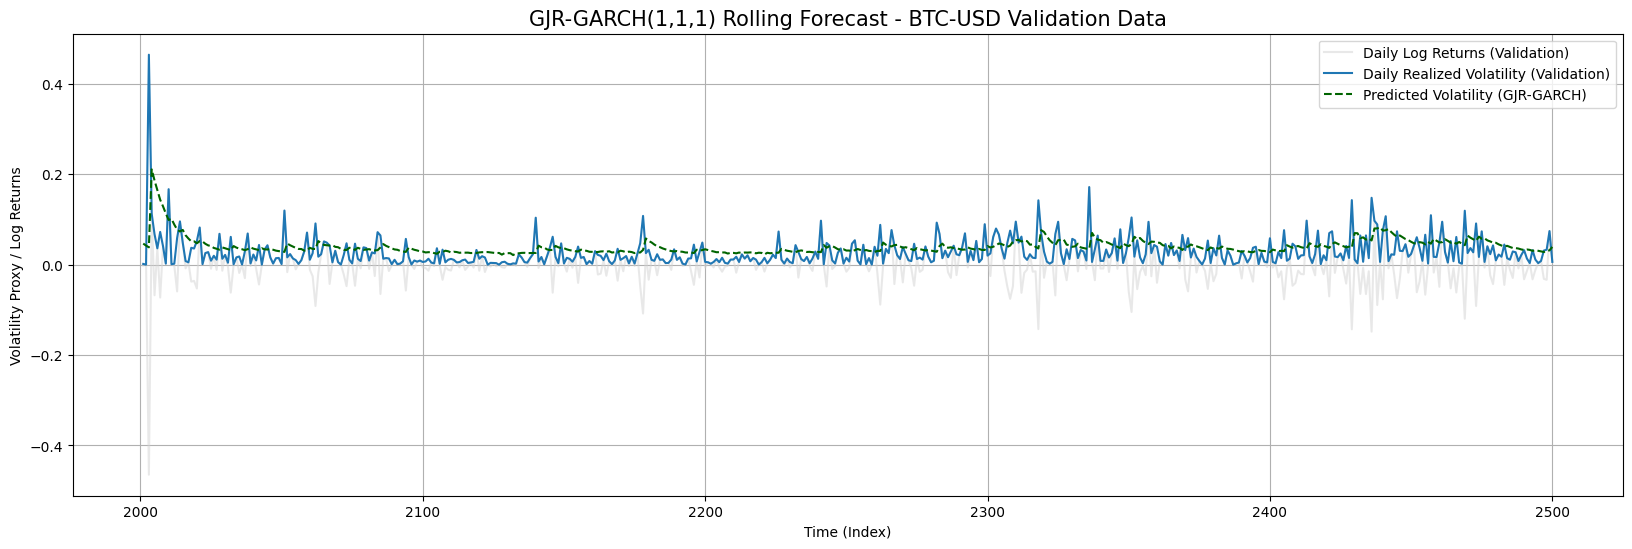

GJR-GARCH Model Rolling Forecast RMSE: 0.037355
GJR-GARCH Model Rolling Forecast RMSPE: 85.198175
Finished GJR-GARCH rolling forecast.


In [15]:
rolling_predictions_gjr = pd.Series(dtype=float) # Initialize
if not ts_val.empty and not log_returns.empty:
    print("Starting GJR-GARCH rolling forecast (this may take time)...")
    rolling_forecasts_gjr_list = []

    for i in range(len(ts_val)):
        current_validation_index_label = val_idx[i]
        loc_current_val_in_log_returns = log_returns.index.get_loc(current_validation_index_label)
        current_training_window = log_returns.iloc[:loc_current_val_in_log_returns]
        
        if len(current_training_window) < 20:
            rolling_forecasts_gjr_list.append(np.nan)
            if i % 50 == 0: print(f"  GJR-GARCH forecast step {i+1}/{len(ts_val)} (skipped)")
            continue
            
        model = arch_model(current_training_window, p=1, o=1, q=1,
                            mean='Zero', vol='GARCH', dist='normal') # o=1 makes it GJR-like
        try:
            model_fit = model.fit(disp='off', show_warning=False)
            pred_variance = model_fit.forecast(horizon=1, reindex=False).variance.iloc[-1,0]
            pred_volatility = np.sqrt(pred_variance)
            rolling_forecasts_gjr_list.append(pred_volatility)
        except Exception as e:
            # print(f"Error fitting GJR-GARCH at validation step {i}: {e}")
            rolling_forecasts_gjr_list.append(np.nan)
        if i % 50 == 0 or i == len(ts_val) -1 : print(f"  GJR-GARCH forecast step {i+1}/{len(ts_val)} completed.")
            
    rolling_predictions_gjr = pd.Series(rolling_forecasts_gjr_list, index=ts_val.index)

    plt.figure(figsize=(20,6))
    plt.plot(ts_val.index, ts_val, color='lightgray', alpha=0.5, label='Daily Log Returns (Validation)')
    plt.plot(vol_val.index, vol_val, label='Daily Realized Volatility (Validation)')
    plt.plot(rolling_predictions_gjr.index, rolling_predictions_gjr, color='darkgreen', linestyle='--', label='Predicted Volatility (GJR-GARCH)')
    plt.title(f'GJR-GARCH(1,1,1) Rolling Forecast - {tckr} Validation Data', fontsize=15)
    plt.xlabel('Time (Index)')
    plt.ylabel('Volatility Proxy / Log Returns')
    plt.legend()
    plt.grid(True)
    plt.show();

    rmse_gjr = RMSE(vol_val, rolling_predictions_gjr)
    rmspe_gjr = RMSPE(vol_val, rolling_predictions_gjr)
    print(f"GJR-GARCH Model Rolling Forecast RMSE: {rmse_gjr:.6f}")
    print(f"GJR-GARCH Model Rolling Forecast RMSPE: {rmspe_gjr:.6f}")
    print("Finished GJR-GARCH rolling forecast.")
else:
    print("Validation or log returns data is empty, skipping GJR-GARCH rolling forecast.")

### EGARCH Model
The EGARCH (Exponential GARCH) model also captures leverage effects. It models the logarithm of the conditional variance, which avoids non-negativity constraints on parameters.
The EGARCH(1,1,1) log conditional variance is:
$$ \ln(\sigma_t^2) = \omega + \beta_1 \ln(\sigma_{t-1}^2) + \alpha_1 \left| \frac{\epsilon_{t-1}}{\sigma_{t-1}} \right| + \gamma_1 \frac{\epsilon_{t-1}}{\sigma_{t-1}} $$
Here, \( \gamma_1 \) captures the leverage effect (sign effect), and \( \alpha_1 \) captures the magnitude effect. A negative \( \gamma_1 \) typically indicates leverage.

Fit to `ts_train` first.

In [16]:
if not ts_train.empty:
    # Define and fit EGARCH(1,1,1) model (p=1, o=1, q=1)
    e_gm_fit = arch_model(ts_train, p=1, o=1, q=1,
                          mean='Zero', vol='EGARCH', dist='normal')
    result_3_egarch = e_gm_fit.fit(disp='off', show_warning=False)
    print("EGARCH(1,1,1) Model Fit Summary (on Training Data, Normal errors):")
    print(result_3_egarch.summary())
else:
    print("Training data (ts_train) is empty, skipping EGARCH model fitting.")
    result_3_egarch = None # Define for safety

EGARCH(1,1,1) Model Fit Summary (on Training Data, Normal errors):
                       Zero Mean - EGARCH Model Results                       
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:                3913.05
Distribution:                  Normal   AIC:                          -7818.10
Method:            Maximum Likelihood   BIC:                          -7795.69
                                        No. Observations:                 2000
Date:                Mon, Feb 02 2026   Df Residuals:                     2000
Time:                        10:16:25   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------

#### EGARCH Rolling Forecast

Starting EGARCH rolling forecast (this may take time)...
  EGARCH forecast step 1/500 completed.
  EGARCH forecast step 51/500 completed.
  EGARCH forecast step 101/500 completed.
  EGARCH forecast step 151/500 completed.
  EGARCH forecast step 201/500 completed.
  EGARCH forecast step 251/500 completed.
  EGARCH forecast step 301/500 completed.
  EGARCH forecast step 351/500 completed.
  EGARCH forecast step 401/500 completed.
  EGARCH forecast step 451/500 completed.
  EGARCH forecast step 500/500 completed.


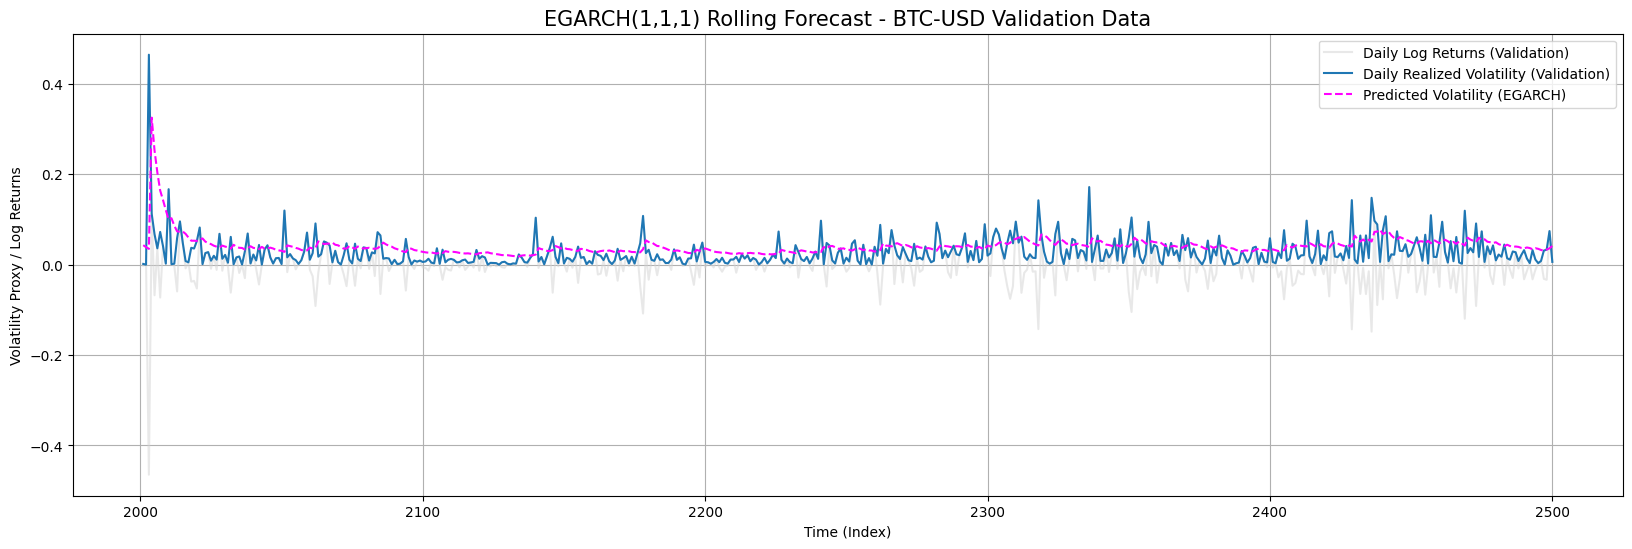

EGARCH Model Rolling Forecast RMSE: 0.039381
EGARCH Model Rolling Forecast RMSPE: 89.095937
Finished EGARCH rolling forecast.


In [17]:
rolling_predictions_egarch = pd.Series(dtype=float) # Initialize
if not ts_val.empty and not log_returns.empty:
    print("Starting EGARCH rolling forecast (this may take time)...")
    rolling_forecasts_egarch_list = []

    for i in range(len(ts_val)):
        current_validation_index_label = val_idx[i]
        loc_current_val_in_log_returns = log_returns.index.get_loc(current_validation_index_label)
        current_training_window = log_returns.iloc[:loc_current_val_in_log_returns]
        
        if len(current_training_window) < 20:
            rolling_forecasts_egarch_list.append(np.nan)
            if i % 50 == 0: print(f"  EGARCH forecast step {i+1}/{len(ts_val)} (skipped)")
            continue
            
        model = arch_model(current_training_window, p=1, o=1, q=1,
                            mean='Zero', vol='EGARCH', dist='normal')
        try:
            model_fit = model.fit(disp='off', show_warning=False)
            pred_variance = model_fit.forecast(horizon=1, reindex=False).variance.iloc[-1,0]
            pred_volatility = np.sqrt(pred_variance)
            rolling_forecasts_egarch_list.append(pred_volatility)
        except Exception as e:
            # print(f"Error fitting EGARCH at validation step {i}: {e}")
            rolling_forecasts_egarch_list.append(np.nan)
        if i % 50 == 0 or i == len(ts_val) -1 : print(f"  EGARCH forecast step {i+1}/{len(ts_val)} completed.")
            
    rolling_predictions_egarch = pd.Series(rolling_forecasts_egarch_list, index=ts_val.index)

    plt.figure(figsize=(20,6))
    plt.plot(ts_val.index, ts_val, color='lightgray', alpha=0.5, label='Daily Log Returns (Validation)')
    plt.plot(vol_val.index, vol_val, label='Daily Realized Volatility (Validation)')
    plt.plot(rolling_predictions_egarch.index, rolling_predictions_egarch, color='magenta', linestyle='--', label='Predicted Volatility (EGARCH)')
    plt.title(f'EGARCH(1,1,1) Rolling Forecast - {tckr} Validation Data', fontsize=15)
    plt.xlabel('Time (Index)')
    plt.ylabel('Volatility Proxy / Log Returns')
    plt.legend()
    plt.grid(True)
    plt.show();

    rmse_egarch = RMSE(vol_val, rolling_predictions_egarch)
    rmspe_egarch = RMSPE(vol_val, rolling_predictions_egarch)
    print(f"EGARCH Model Rolling Forecast RMSE: {rmse_egarch:.6f}")
    print(f"EGARCH Model Rolling Forecast RMSPE: {rmspe_egarch:.6f}")
    print("Finished EGARCH rolling forecast.")
else:
    print("Validation or log returns data is empty, skipping EGARCH rolling forecast.")

### EGARCH Model with Student's t-Distribution
Financial returns often exhibit 'fat tails' (leptokurtosis), meaning extreme events are more common than a Normal distribution suggests. The Student's t-distribution can better capture this. We fit an EGARCH model assuming Student's t-distributed errors.
The model summary will include an estimate for the degrees of freedom (`nu`) of the t-distribution. A small, significant `nu` suggests fat tails.

In [18]:
if not ts_train.empty:
    # Define and fit EGARCH(1,1,1) with Student's t-distribution
    e_gm_t_fit = arch_model(ts_train, p=1, o=1, q=1,
                            mean='Zero', vol='EGARCH', dist='StudentsT')
    result_4_egarch_t = e_gm_t_fit.fit(disp='off', show_warning=False)
    print("EGARCH(1,1,1) Model Fit Summary (on Training Data, Student's t errors):")
    print(result_4_egarch_t.summary())
else:
    print("Training data (ts_train) is empty, skipping EGARCH-t model fitting.")
    result_4_egarch_t = None # Define for safety

EGARCH(1,1,1) Model Fit Summary (on Training Data, Student's t errors):
                          Zero Mean - EGARCH Model Results                          
Dep. Variable:                        Close   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.000
Vol Model:                           EGARCH   Log-Likelihood:                4193.61
Distribution:      Standardized Student's t   AIC:                          -8377.23
Method:                  Maximum Likelihood   BIC:                          -8349.22
                                              No. Observations:                 2000
Date:                      Mon, Feb 02 2026   Df Residuals:                     2000
Time:                              10:16:36   Df Model:                            0
                               Volatility Model                               
                  coef    std err          t      P>|t|       95.0% Conf. Int.
-----

#### EGARCH with Student's t-Distribution Rolling Forecast

Starting EGARCH-t rolling forecast (this may take time)...
  EGARCH-t forecast step 1/500 completed.
  EGARCH-t forecast step 51/500 completed.
  EGARCH-t forecast step 101/500 completed.
  EGARCH-t forecast step 151/500 completed.
  EGARCH-t forecast step 201/500 completed.
  EGARCH-t forecast step 251/500 completed.
  EGARCH-t forecast step 301/500 completed.
  EGARCH-t forecast step 351/500 completed.
  EGARCH-t forecast step 401/500 completed.
  EGARCH-t forecast step 451/500 completed.
  EGARCH-t forecast step 500/500 completed.


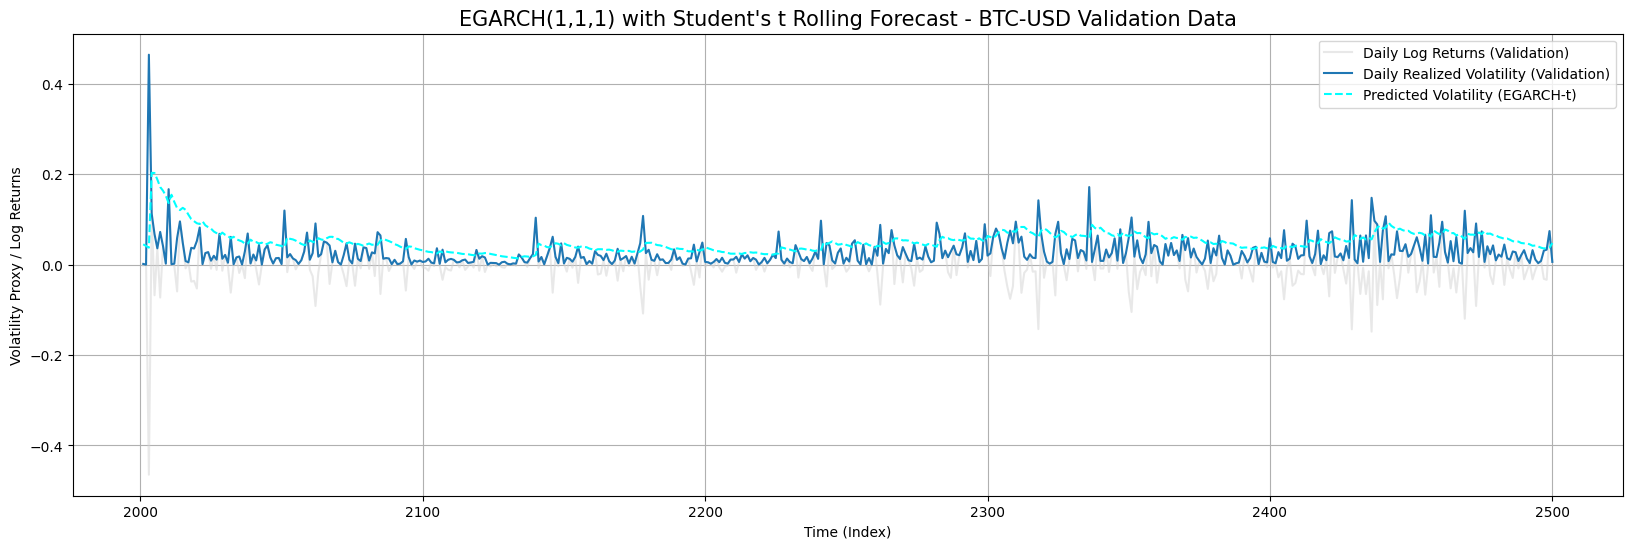

EGARCH-t Model Rolling Forecast RMSE: 0.044668
EGARCH-t Model Rolling Forecast RMSPE: 113.393127
Finished EGARCH-t rolling forecast.


In [19]:
rolling_predictions_egarch_t = pd.Series(dtype=float) # Initialize
if not ts_val.empty and not log_returns.empty:
    print("Starting EGARCH-t rolling forecast (this may take time)...")
    rolling_forecasts_egarch_t_list = []

    for i in range(len(ts_val)):
        current_validation_index_label = val_idx[i]
        loc_current_val_in_log_returns = log_returns.index.get_loc(current_validation_index_label)
        current_training_window = log_returns.iloc[:loc_current_val_in_log_returns]
        
        if len(current_training_window) < 20:
            rolling_forecasts_egarch_t_list.append(np.nan)
            if i % 50 == 0: print(f"  EGARCH-t forecast step {i+1}/{len(ts_val)} (skipped)")
            continue
            
        model = arch_model(current_training_window, p=1, o=1, q=1,
                            mean='Zero', vol='EGARCH', dist='StudentsT')
        try:
            model_fit = model.fit(disp='off', show_warning=False)
            pred_variance = model_fit.forecast(horizon=1, reindex=False).variance.iloc[-1,0]
            pred_volatility = np.sqrt(pred_variance)
            rolling_forecasts_egarch_t_list.append(pred_volatility)
        except Exception as e:
            # print(f"Error fitting EGARCH-t at validation step {i}: {e}")
            rolling_forecasts_egarch_t_list.append(np.nan)
        if i % 50 == 0 or i == len(ts_val) -1 : print(f"  EGARCH-t forecast step {i+1}/{len(ts_val)} completed.")
            
    rolling_predictions_egarch_t = pd.Series(rolling_forecasts_egarch_t_list, index=ts_val.index)

    plt.figure(figsize=(20,6))
    plt.plot(ts_val.index, ts_val, color='lightgray', alpha=0.5, label='Daily Log Returns (Validation)')
    plt.plot(vol_val.index, vol_val, label='Daily Realized Volatility (Validation)')
    plt.plot(rolling_predictions_egarch_t.index, rolling_predictions_egarch_t, color='cyan', linestyle='--', label='Predicted Volatility (EGARCH-t)')
    plt.title(f'EGARCH(1,1,1) with Student\'s t Rolling Forecast - {tckr} Validation Data', fontsize=15)
    plt.xlabel('Time (Index)')
    plt.ylabel('Volatility Proxy / Log Returns')
    plt.legend()
    plt.grid(True)
    plt.show();

    rmse_egarch_t = RMSE(vol_val, rolling_predictions_egarch_t)
    rmspe_egarch_t = RMSPE(vol_val, rolling_predictions_egarch_t)
    print(f"EGARCH-t Model Rolling Forecast RMSE: {rmse_egarch_t:.6f}")
    print(f"EGARCH-t Model Rolling Forecast RMSPE: {rmspe_egarch_t:.6f}")
    print("Finished EGARCH-t rolling forecast.")
else:
    print("Validation or log returns data is empty, skipping EGARCH-t rolling forecast.")

## 10. LSTM Model for Volatility Forecasting

We now explore a deep learning approach using a Long Short-Term Memory (LSTM) network. LSTMs are a type of recurrent neural network (RNN) well-suited for sequence data like time series.

### Data Preparation for LSTM
LSTMs require input data to be structured into 'windows' or sequences. The `windowed_dataset` function prepares the `vol_train` series (our volatility proxy) by:
1. Creating sliding windows of `window_size + 1` elements.
2. For each window, the first `window_size` elements are features (past volatilities), and the last element is the label (future volatility to predict).
3. Shuffling and batching the data for training.

LSTM Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ (None, None, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 28)             │         3,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            29 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,389 (13.24 KB)

 Trainable params: 3,389 (13.24 KB)

 Non-trainable params: 0 (0.00 B)


Starting LSTM model training (this may take time)...
Epoch 1/100
63/63 - 1s - 13ms/step - loss: 7.9599e-04
Epoch 2/100
63/63 - 0s - 2ms/step - loss: 7.6222e-04
Epoch 3/100


2026-02-02 10:16:57.100316: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2026-02-02 10:16:57.237977: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.4540e-04
Epoch 4/100
63/63 - 0s - 2ms/step - loss: 7.4837e-04
Epoch 5/100


2026-02-02 10:16:57.378235: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2026-02-02 10:16:57.501952: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.3904e-04
Epoch 6/100
63/63 - 0s - 2ms/step - loss: 7.3817e-04
Epoch 7/100


2026-02-02 10:16:57.626103: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2026-02-02 10:16:57.748833: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.5073e-04
Epoch 8/100
63/63 - 0s - 2ms/step - loss: 7.4393e-04
Epoch 9/100


2026-02-02 10:16:57.871731: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2026-02-02 10:16:57.994296: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.3534e-04
Epoch 10/100
63/63 - 0s - 2ms/step - loss: 7.4324e-04
Epoch 11/100


2026-02-02 10:16:58.118420: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2026-02-02 10:16:58.240628: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.4364e-04
Epoch 12/100
63/63 - 0s - 2ms/step - loss: 7.3580e-04
Epoch 13/100


2026-02-02 10:16:58.363333: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2026-02-02 10:16:58.485137: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.4240e-04
Epoch 14/100
63/63 - 0s - 2ms/step - loss: 7.3867e-04
Epoch 15/100


2026-02-02 10:16:58.609088: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2026-02-02 10:16:58.731189: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.3741e-04
Epoch 16/100
63/63 - 0s - 2ms/step - loss: 7.3484e-04
Epoch 17/100


2026-02-02 10:16:58.854368: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2026-02-02 10:16:58.975167: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.4304e-04
Epoch 18/100
63/63 - 0s - 2ms/step - loss: 7.4552e-04
Epoch 19/100


2026-02-02 10:16:59.098266: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2026-02-02 10:16:59.220517: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.3542e-04
Epoch 20/100
63/63 - 0s - 2ms/step - loss: 7.4391e-04
Epoch 21/100


2026-02-02 10:16:59.343145: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2026-02-02 10:16:59.465177: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.2907e-04
Epoch 22/100
63/63 - 0s - 2ms/step - loss: 7.3409e-04
Epoch 23/100


2026-02-02 10:16:59.587512: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2026-02-02 10:16:59.710318: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.3276e-04
Epoch 24/100
63/63 - 0s - 2ms/step - loss: 7.3933e-04
Epoch 25/100


2026-02-02 10:16:59.834168: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2026-02-02 10:16:59.982007: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.4050e-04
Epoch 26/100
63/63 - 0s - 2ms/step - loss: 7.4048e-04
Epoch 27/100


2026-02-02 10:17:00.137657: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2026-02-02 10:17:00.286053: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 3ms/step - loss: 7.3297e-04
Epoch 28/100
63/63 - 0s - 2ms/step - loss: 7.3363e-04
Epoch 29/100


2026-02-02 10:17:00.456855: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2026-02-02 10:17:00.592103: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.4775e-04
Epoch 30/100
63/63 - 0s - 2ms/step - loss: 7.3120e-04
Epoch 31/100


2026-02-02 10:17:00.719734: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2026-02-02 10:17:00.843565: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.3494e-04
Epoch 32/100
63/63 - 0s - 2ms/step - loss: 7.3209e-04
Epoch 33/100


2026-02-02 10:17:00.972686: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2026-02-02 10:17:01.110351: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.3134e-04
Epoch 34/100
63/63 - 0s - 2ms/step - loss: 7.3084e-04
Epoch 35/100


2026-02-02 10:17:01.241378: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2026-02-02 10:17:01.367733: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.3575e-04
Epoch 36/100
63/63 - 0s - 2ms/step - loss: 7.3368e-04
Epoch 37/100


2026-02-02 10:17:01.518585: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2026-02-02 10:17:01.648346: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.3788e-04
Epoch 38/100
63/63 - 0s - 2ms/step - loss: 7.3257e-04
Epoch 39/100


2026-02-02 10:17:01.771907: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2026-02-02 10:17:01.923787: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.4052e-04
Epoch 40/100
63/63 - 0s - 2ms/step - loss: 7.4106e-04
Epoch 41/100


2026-02-02 10:17:02.063413: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2026-02-02 10:17:02.196164: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.3427e-04
Epoch 42/100
63/63 - 0s - 2ms/step - loss: 7.3432e-04
Epoch 43/100


2026-02-02 10:17:02.328479: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2026-02-02 10:17:02.474230: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.3110e-04
Epoch 44/100
63/63 - 0s - 2ms/step - loss: 7.4260e-04
Epoch 45/100


2026-02-02 10:17:02.619026: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2026-02-02 10:17:02.746588: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.3799e-04
Epoch 46/100
63/63 - 0s - 2ms/step - loss: 7.3009e-04
Epoch 47/100


2026-02-02 10:17:02.895312: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2026-02-02 10:17:03.026851: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.3323e-04
Epoch 48/100
63/63 - 0s - 2ms/step - loss: 7.3465e-04
Epoch 49/100


2026-02-02 10:17:03.150426: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2026-02-02 10:17:03.272655: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.3321e-04
Epoch 50/100
63/63 - 0s - 2ms/step - loss: 7.3570e-04
Epoch 51/100


2026-02-02 10:17:03.418231: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2026-02-02 10:17:03.548904: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.4613e-04
Epoch 52/100
63/63 - 0s - 2ms/step - loss: 7.3379e-04
Epoch 53/100


2026-02-02 10:17:03.694916: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2026-02-02 10:17:03.824801: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.3714e-04
Epoch 54/100
63/63 - 0s - 2ms/step - loss: 7.3277e-04
Epoch 55/100


2026-02-02 10:17:03.973463: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2026-02-02 10:17:04.107488: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.2842e-04
Epoch 56/100
63/63 - 0s - 2ms/step - loss: 7.2777e-04
Epoch 57/100


2026-02-02 10:17:04.244253: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2026-02-02 10:17:04.377123: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.3631e-04
Epoch 58/100
63/63 - 0s - 2ms/step - loss: 7.3288e-04
Epoch 59/100


2026-02-02 10:17:04.516263: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2026-02-02 10:17:04.643141: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.2913e-04
Epoch 60/100
63/63 - 0s - 3ms/step - loss: 7.3306e-04
Epoch 61/100


2026-02-02 10:17:04.788532: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2026-02-02 10:17:04.952879: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.2980e-04
Epoch 62/100
63/63 - 0s - 2ms/step - loss: 7.4057e-04
Epoch 63/100


2026-02-02 10:17:05.087969: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2026-02-02 10:17:05.211703: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.3210e-04
Epoch 64/100
63/63 - 0s - 2ms/step - loss: 7.3456e-04
Epoch 65/100


2026-02-02 10:17:05.335963: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2026-02-02 10:17:05.480399: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.2961e-04
Epoch 66/100
63/63 - 0s - 2ms/step - loss: 7.4203e-04
Epoch 67/100


2026-02-02 10:17:05.607513: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2026-02-02 10:17:05.754152: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.3063e-04
Epoch 68/100
63/63 - 0s - 2ms/step - loss: 7.3753e-04
Epoch 69/100


2026-02-02 10:17:05.901060: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2026-02-02 10:17:06.025114: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.3201e-04
Epoch 70/100
63/63 - 0s - 2ms/step - loss: 7.3130e-04
Epoch 71/100


2026-02-02 10:17:06.148614: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2026-02-02 10:17:06.275095: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.3432e-04
Epoch 72/100
63/63 - 0s - 2ms/step - loss: 7.4160e-04
Epoch 73/100


2026-02-02 10:17:06.420897: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2026-02-02 10:17:06.543686: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.2932e-04
Epoch 74/100
63/63 - 0s - 2ms/step - loss: 7.3340e-04
Epoch 75/100


2026-02-02 10:17:06.667364: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2026-02-02 10:17:06.790203: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.3010e-04
Epoch 76/100
63/63 - 0s - 2ms/step - loss: 7.3884e-04
Epoch 77/100


2026-02-02 10:17:06.913432: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2026-02-02 10:17:07.036229: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.2839e-04
Epoch 78/100
63/63 - 0s - 2ms/step - loss: 7.3307e-04
Epoch 79/100


2026-02-02 10:17:07.159132: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2026-02-02 10:17:07.280493: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.2923e-04
Epoch 80/100
63/63 - 0s - 2ms/step - loss: 7.3526e-04
Epoch 81/100


2026-02-02 10:17:07.403643: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2026-02-02 10:17:07.525701: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.2862e-04
Epoch 82/100
63/63 - 0s - 2ms/step - loss: 7.2994e-04
Epoch 83/100


2026-02-02 10:17:07.649638: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2026-02-02 10:17:07.793190: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.2927e-04
Epoch 84/100
63/63 - 0s - 2ms/step - loss: 7.3215e-04
Epoch 85/100


2026-02-02 10:17:07.915905: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2026-02-02 10:17:08.037946: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.3248e-04
Epoch 86/100
63/63 - 0s - 2ms/step - loss: 7.3448e-04
Epoch 87/100


2026-02-02 10:17:08.160618: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2026-02-02 10:17:08.282820: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.3458e-04
Epoch 88/100
63/63 - 0s - 2ms/step - loss: 7.4335e-04
Epoch 89/100


2026-02-02 10:17:08.406198: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2026-02-02 10:17:08.528941: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.2776e-04
Epoch 90/100
63/63 - 0s - 2ms/step - loss: 7.3513e-04
Epoch 91/100


2026-02-02 10:17:08.653661: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2026-02-02 10:17:08.776208: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.2686e-04
Epoch 92/100
63/63 - 0s - 2ms/step - loss: 7.3980e-04
Epoch 93/100


2026-02-02 10:17:08.899215: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2026-02-02 10:17:09.021937: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.2731e-04
Epoch 94/100
63/63 - 0s - 2ms/step - loss: 7.3041e-04
Epoch 95/100


2026-02-02 10:17:09.170326: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2026-02-02 10:17:09.292927: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.2831e-04
Epoch 96/100
63/63 - 0s - 2ms/step - loss: 7.3247e-04
Epoch 97/100


2026-02-02 10:17:09.416955: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2026-02-02 10:17:09.539353: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.3001e-04
Epoch 98/100
63/63 - 0s - 2ms/step - loss: 7.3962e-04
Epoch 99/100


2026-02-02 10:17:09.662078: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2026-02-02 10:17:09.794826: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


63/63 - 0s - 2ms/step - loss: 7.2867e-04
Epoch 100/100
63/63 - 0s - 2ms/step - loss: 7.3095e-04
Finished LSTM model training.


2026-02-02 10:17:09.918305: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2026-02-02 10:17:10.040374: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


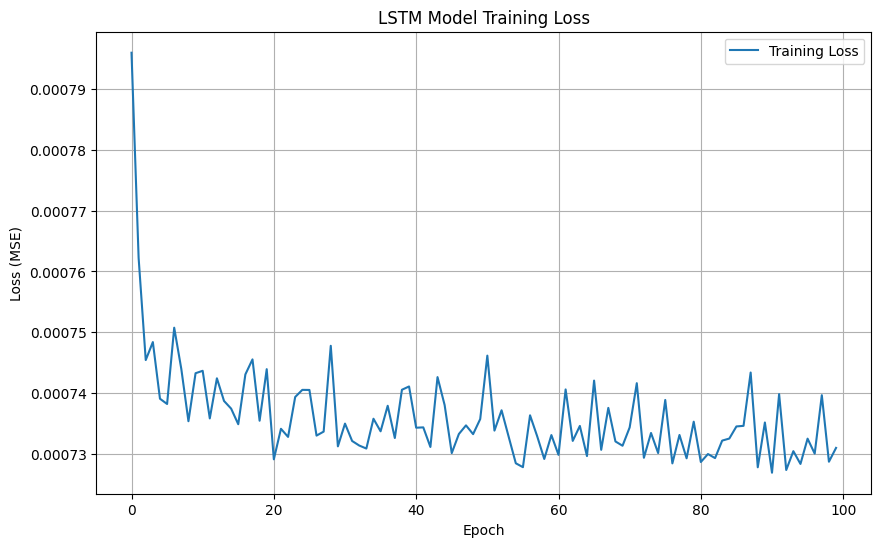

In [20]:
# Function to create windowed dataset for TensorFlow/Keras
def windowed_dataset_tf(series, window_size, batch_size, shuffle_buffer):
    # Ensure series is a NumPy array or TensorFlow tensor for from_tensor_slices
    if isinstance(series, pd.Series):
        series_values = series.values
    elif isinstance(series, np.ndarray):
        series_values = series
    else:
        # Assuming it's already a tensor or compatible type
        series_values = series 
        
    dataset = tf.data.Dataset.from_tensor_slices(series_values)
    # Create windows of (window_size features + 1 label)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    # Flatten windows into batches of (window_size + 1) elements
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    # Shuffle windows and map to (features, label) tuples
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    # Batch the (features, label) tuples and prefetch for performance
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

# Initialize LSTM model variable
lstm_model_trained = None
lstm_history_log = None

if not vol_train.empty:
    # LSTM Hyperparameters
    window_size_lstm = 14 # Number of past volatility values to use as input
    batch_size_lstm = 32   # Number of training examples utilized in one iteration
    shuffle_buffer_size_lstm = 1000 # Buffer size for shuffling data

    # Ensure vol_train has enough data for at least one window
    if len(vol_train) > window_size_lstm:
        # Create the windowed dataset from training volatility data
        train_dataset_lstm = windowed_dataset_tf(vol_train, window_size_lstm, batch_size_lstm, shuffle_buffer_size_lstm)

        # Define the LSTM model structure
        lstm_model_trained = tf.keras.models.Sequential([
            # Lambda layer to reshape input for LSTM: (batch, timesteps) -> (batch, timesteps, 1 feature)
            tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                                     input_shape=[None]), # Or input_shape=[window_size_lstm] for fixed size
            # LSTM layer with 28 units. Standard activations are tanh (output) and sigmoid (recurrent).
            tf.keras.layers.LSTM(28, activation='tanh', recurrent_activation='sigmoid'),
            # Dense output layer with 1 unit for single-step volatility prediction
            tf.keras.layers.Dense(1)
        ])

        # Compile the LSTM model
        lstm_model_trained.compile(optimizer='adam', loss='mse') # Adam optimizer, Mean Squared Error loss
        print("LSTM Model Summary:")
        lstm_model_trained.summary()
        
        print("\nStarting LSTM model training (this may take time)...")
        # Train the model. The batch_size in fit() is often ignored when using tf.data.Dataset 
        # as the dataset is already batched.
        lstm_history_log = lstm_model_trained.fit(train_dataset_lstm, epochs=100, verbose=2)
        print("Finished LSTM model training.")
        
        # Plot training loss
        plt.figure(figsize=(10, 6))
        plt.plot(lstm_history_log.history['loss'], label='Training Loss')
        plt.title('LSTM Model Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss (MSE)')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print(f"Training volatility data (vol_train, length {len(vol_train)}) is too short for LSTM window_size {window_size_lstm}.")
        print("Skipping LSTM model training.")
else:
    print("Training volatility data (vol_train) is empty, skipping LSTM model setup and training.")

### LSTM Rolling Prediction
We generate 1-step ahead predictions on the validation set using the trained LSTM model. For each point in `vol_val`:
1. We take the preceding `window_size_lstm` actual volatility values from the `vols` series.
2. This window is fed to the LSTM model to predict the next volatility value.

Starting LSTM rolling prediction on validation set...
  LSTM forecast step 1/500 completed.
  LSTM forecast step 51/500 completed.
  LSTM forecast step 101/500 completed.
  LSTM forecast step 151/500 completed.
  LSTM forecast step 201/500 completed.
  LSTM forecast step 251/500 completed.
  LSTM forecast step 301/500 completed.
  LSTM forecast step 351/500 completed.
  LSTM forecast step 401/500 completed.
  LSTM forecast step 451/500 completed.
  LSTM forecast step 500/500 completed.


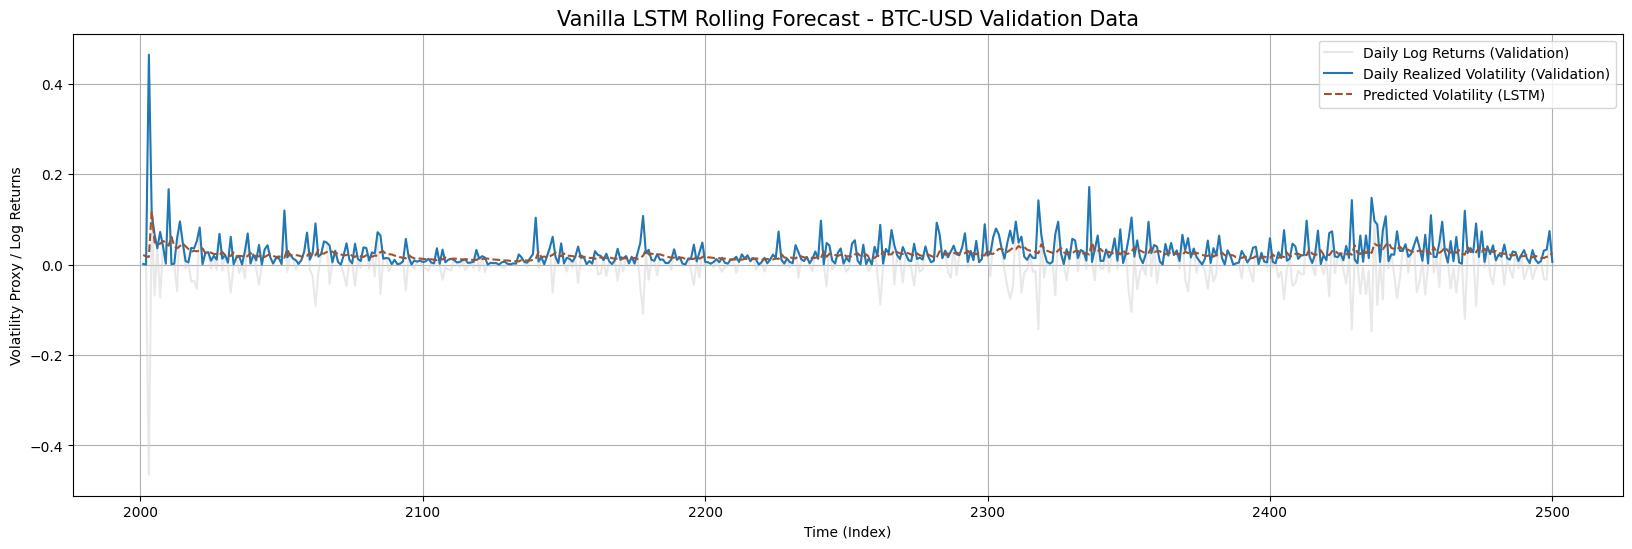

LSTM Model Rolling Forecast RMSE: 0.034182
LSTM Model Rolling Forecast RMSPE: 49.949692
Finished LSTM rolling prediction.


In [21]:
rolling_predictions_lstm = pd.Series(dtype=float) # Initialize

if lstm_model_trained is not None and not vol_val.empty and not vols.empty:
    print("Starting LSTM rolling prediction on validation set...")
    lstm_forecast_values_list = []
    full_vols_index = vols.index # Index of the entire 'vols' series

    # Iterate to make predictions for each point in the validation set
    for i in range(len(vol_val)):
        # Determine the position of the current validation point in the full 'vols' series
        current_validation_index_label = val_idx[i]
        try:
            current_validation_point_loc_in_full_series = full_vols_index.get_loc(current_validation_index_label)
        except KeyError:
            # print(f"Validation index {current_validation_index_label} not found in full vols index. Skipping LSTM step {i}.")
            lstm_forecast_values_list.append(np.nan)
            if i % 50 == 0: print(f"  LSTM forecast step {i+1}/{len(vol_val)} (skipped, index error)")
            continue
        
        # Define the start and end positions for the input window from the full 'vols' series
        input_window_start_pos = current_validation_point_loc_in_full_series - window_size_lstm
        input_window_end_pos = current_validation_point_loc_in_full_series -1 # End is exclusive for slicing, so -1 is correct

        if input_window_start_pos < 0:
            # Not enough historical data for a full window
            lstm_forecast_values_list.append(np.nan)
            if i % 50 == 0: print(f"  LSTM forecast step {i+1}/{len(vol_val)} (skipped, insufficient history)")
            continue
        
        # Extract the input window using positional indexing on the 'vols' series values
        input_sequence = vols.iloc[input_window_start_pos : input_window_end_pos + 1].values
        
        if len(input_sequence) == window_size_lstm:
            # Reshape input for LSTM: (window_size,) -> (1, window_size)
            # The Lambda layer in the model will add the feature dimension: (1, window_size, 1)
            pred_input_lstm = input_sequence[np.newaxis, :]
            prediction_result_lstm = lstm_model_trained.predict(pred_input_lstm, verbose=0) # verbose=0 for no predict output
            lstm_forecast_values_list.append(prediction_result_lstm[0,0])
        else:
            # This case should ideally not be hit if indexing is correct and data is sufficient
            lstm_forecast_values_list.append(np.nan)
        if i % 50 == 0 or i == len(vol_val) -1 : print(f"  LSTM forecast step {i+1}/{len(vol_val)} completed.")

    # Create a Pandas Series for the LSTM predictions, aligned with validation set index
    rolling_predictions_lstm = pd.Series(lstm_forecast_values_list, index=ts_val.index)

    # Visualize LSTM predictions
    plt.figure(figsize=(20,6))
    plt.plot(ts_val.index, ts_val, color='lightgray', alpha=0.5, label='Daily Log Returns (Validation)')
    plt.plot(vol_val.index, vol_val, label='Daily Realized Volatility (Validation)')
    plt.plot(rolling_predictions_lstm.index, rolling_predictions_lstm, color='sienna', linestyle='--', label='Predicted Volatility (LSTM)')
    plt.title(f'Vanilla LSTM Rolling Forecast - {tckr} Validation Data', fontsize=15)
    plt.xlabel('Time (Index)')
    plt.ylabel('Volatility Proxy / Log Returns')
    plt.legend()
    plt.grid(True)
    plt.show();

    # Evaluate LSTM Model
    rmse_lstm = RMSE(vol_val, rolling_predictions_lstm)
    rmspe_lstm = RMSPE(vol_val, rolling_predictions_lstm)
    print(f"LSTM Model Rolling Forecast RMSE: {rmse_lstm:.6f}")
    print(f"LSTM Model Rolling Forecast RMSPE: {rmspe_lstm:.6f}")
    print("Finished LSTM rolling prediction.")
else:
    print("LSTM model was not trained or validation/vols data is empty. Skipping LSTM prediction.")

## 11. Model Comparison (Summary of Results)

Collect all the RMSE and RMSPE values from each model evaluated on the validation set and compare them to determine which model performed best for this specific dataset and task.

**Example Table (fill with actual values printed during the notebook execution):**

| Model                                  | RMSE     | RMSPE    |
|----------------------------------------|----------|----------|
| Baseline (Mean)                        |0.034473  |65.601969 |
| Baseline (Random Walk)                 |0.046653  |48.957284 |
| GARCH(1,1) - Normal                    |0.037767  |84.328945 |
| GJR-GARCH(1,1,1) - Normal              |0.037355  |85.198175 |
| EGARCH(1,1,1) - Normal                 |0.039381  |89.095937 |
| EGARCH(1,1,1) - Student's t            |0.044668  |113.393127|
| LSTM                                   |0.033782  |66.260657 |

The model with the lowest error metrics (considering both RMSE and RMSPE, and potentially other factors like model complexity or interpretability) would be considered the best performing on the validation data.